In [1]:
%load_ext cython
import speckle_tracking as st
import pyrost as rst
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import concurrent.futures
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, uniform_filter, convolve1d
from scipy.integrate import quad
from scipy.optimize import least_squares
from importlib import reload

pyximport.install(reload_support=True)

(None, <pyximport.pyximport.PyxImporter at 0x7ff5702489d0>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'bnprd_var', 'bprd_var', 'ct_integrate', 'gaussian_filter', 'init_newton', 'krig_data', 'make_frames', 'make_reference', 'mse_2d', 'np', 'pixel_translations', 'st', 'st_update', 'str_update', 'subpixel_refinement_1d', 'subpixel_refinement_2d', 'total_mse', 'update_pixel_map_gs', 'upm_newton_1d']


In [3]:
def ab_model(pix, coeff):
    return coeff[0] + coeff[1] * (pix - coeff[3]) + coeff[2] * (pix - coeff[3])**2

def ab_errors(coeff, data):
    return ab_model(data[:, 0], coeff) - data[:, 1]

def ph_model(theta, coeff):
    return coeff[0] + coeff[1] * (theta - coeff[4]) + \
           coeff[2] * (theta - coeff[4])**2 + coeff[3] * (theta - coeff[4])**3

def ph_errors(coeff, data):
    return ph_model(data[:, 0], coeff) - data[:, 1]

def phase_fit(u, x_ps, z, df, wl, l_scale=5, max_order=4, roi=None):
    # calculate the phase
    if roi is None:
        roi = (0, u.shape[-1])
    u_pix = (u - np.indices((u.shape[1], u.shape[2])))[1, 0, roi[0]:roi[1]]
    ang = u_pix * x_ps / z
    phase = np.cumsum(ang) * x_ps * df / z * 2 * np.pi / wl
    pix = np.arange(u.shape[2])[roi[0]:roi[1]]
    x, theta = pix * x_ps, pix * x_ps / z
    data = np.stack((pix, gaussian_filter(u_pix, l_scale)), axis=-1)

    # find a min/max argument
    u0 = gaussian_filter(u_pix, u_pix.shape[0] / 10)
    if np.median(np.gradient(np.gradient(u0))) > 0:
        idx = np.argmin(u0)
    else:
        idx = np.argmax(u0)

        
    # fit the model to the data
    bounds = ([-np.inf, -np.inf, -np.inf, 0],
              [np.inf, np.inf, np.inf, u_pix.shape[0]])
    fit = least_squares(ab_errors, np.array([0, 0, 0, pix[idx]]), args=(data,),
                          xtol=1e-14, ftol=1e-14, bounds=bounds, loss='cauchy')
    ang_fit = np.array([fit.x[0], fit.x[1] / (x_ps / z),
                        fit.x[2] / (x_ps / z)**2, fit.x[3]]) * x_ps / z
    ph_fit = np.zeros(5)
    ph_fit[1:] = ang_fit; ph_fit[1:-1] *= 2 * np.pi / wl * df / (np.arange(3) + 1)
    ph_fit[0] = np.mean(phase - ph_model(theta, ph_fit))

    # evaluating errors
    r_sq = 1 - np.sum(ab_errors(fit.x, data)**2) / np.sum((data[:, 1] - data[:, 1].mean())**2)
    return {'pix': pix, 'theta': theta, 'u_pix': u_pix, 'angles': ang, 'phase': phase,
            'fit': fit, 'ang_fit': ang_fit, 'ph_fit': ph_fit, 'r_sq': r_sq}

# ST Simulation

In [5]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.12, bar_atn=0.18,
                           bulk_atn=0.2, p0 = 5e4, th_s=8e-5, n_frames=200,
                           offset=2.0, step_size=0.1, defocus=150, alpha=0.05,
                           x0=0.7, rnd_dev=0.4)

globals().update(**params.export_dict())
print(params)

{'defocus': 150.0, 'det_dist': 2000000.0, 'step_size': 0.1, 'n_frames': 200, 'fs_size': 2000, 'ss_size': 1000, 'pix_size': 55.0, 'p0': 50000.0, 'wl': 7.29e-05, 'th_s': 8e-05, 'ap_x': 40.0, 'ap_y': 2.0, 'focus': 1500.0, 'alpha': 0.05, 'x0': 0.7, 'bar_size': 0.7, 'bar_sigma': 0.12, 'bar_atn': 0.18, 'bulk_atn': 0.2, 'rnd_dev': 0.4, 'offset': 2.0, 'verbose': True}


In [6]:
n_x = int(1.6 * ap_x / focus * defocus * fs_size * pix_size / wl / det_dist)
n_y = int(1.2 * ap_y * ss_size * pix_size / wl / det_dist)
x_arr = np.linspace(-0.8 * ap_x / focus * defocus, 0.8 * ap_x / focus * defocus, n_x)
y_arr = np.linspace(-0.6 * ap_y, 0.6 * ap_y, n_y)
xx_arr = pix_size * np.arange(-fs_size // 2, fs_size // 2)
yy_arr = pix_size * np.arange(-ss_size // 2, ss_size // 2)
print(n_x, n_y)

4828 905


In [7]:
wf0_x = lens_wp(x_arr, wl, ap_x, focus, defocus, alpha, (x0 - 0.5) * ap_x)
wf0_y = aperture_wp(y_arr, focus + defocus, wl, ap_y)
wf1_y = fraunhofer_1d(wf0_y, y_arr, yy_arr, det_dist, wl)

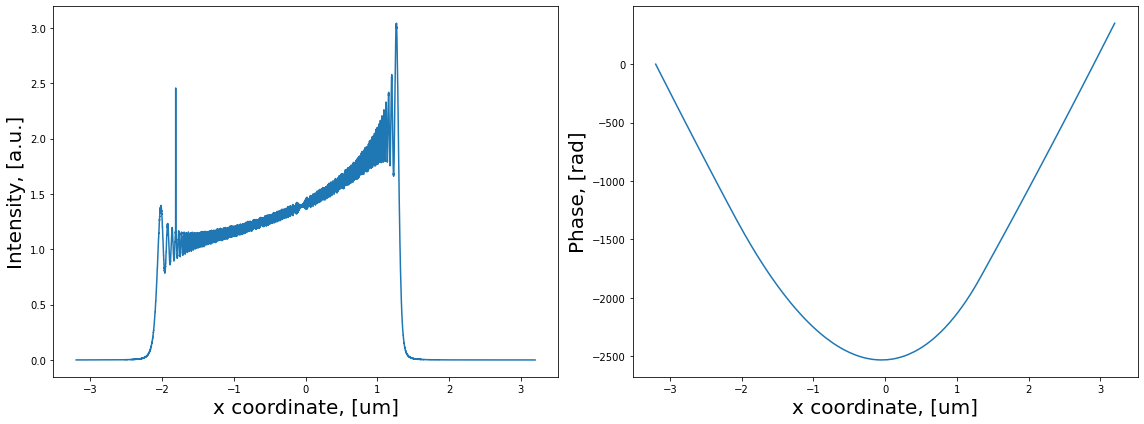

In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(x_arr, np.unwrap(np.angle(wf0_x)))
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_x.pdf')

In [26]:
fx_lim = np.array([-0.45 * ap_x / focus, 0.5 * ap_x / focus])
th_lim = fx_lim - wl / 2 / np.pi * alpha * 3e9 * fx_lim**2 / defocus
beam_span = np.clip(th_lim * defocus, x_arr[0], x_arr[-1])
wf0_roi = ((beam_span - x_arr[0]) // (x_arr[1] - x_arr[0])).astype(np.int)
xr_arr = x_arr[wf0_roi[0]:wf0_roi[1]]
wf0_ph = np.unwrap(np.angle(wf0_x))
wf0_ph_fc = np.polyfit(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], 3)
df_fit = np.pi / wl / wf0_ph_fc[1]
alpha_fit = wf0_ph_fc[0] * df_fit**3 * 1e-9
wf0_ph_fit = np.pi * xr_arr**2 / wl / df_fit + alpha_fit * 1e9 * (xr_arr / df_fit)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
wf0_ph_th = np.pi * xr_arr**2 / wl / defocus + alpha * 1e9 * (xr_arr / defocus)**3 + wf0_ph[np.searchsorted(x_arr, 0)]
print(df_fit, alpha_fit)

126.87478284567361 0.04208576552419257


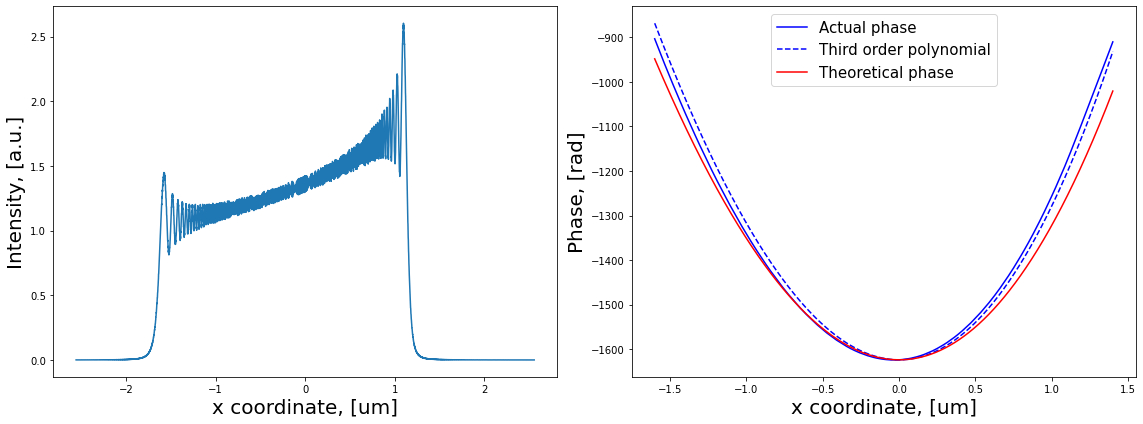

In [12]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[0].set_ylabel('Intensity, [a.u.]', fontsize=20)
axes[1].plot(xr_arr, wf0_ph[wf0_roi[0]:wf0_roi[1]], label='Actual phase', color='b')
axes[1].plot(xr_arr, wf0_ph_fit, color='b', label='Third order polynomial', linestyle='dashed')
axes[1].plot(xr_arr, wf0_ph_th, color='r', label='Theoretical phase')
axes[1].set_ylabel('Phase, [rad]', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
plt.tight_layout(h_pad=0.2)
plt.show()
# plt.savefig('figures/wf0_phase_2.pdf')

In [37]:
# bsteps = barcode_steps(x0=x_arr[0] + offset, x1=x_arr[-1] + n_frames * step_size - offset + 0.1,
#                        br_dx=bar_size, rd=rnd_dev)
bsteps = dev.barcode_steps(x0=x_arr[0] + offset, x1=x_arr[-1] + n_frames * step_size - offset + 0.1,
                       br_dx=bar_size, rd=rnd_dev)
print(bsteps, bsteps2.shape)

[-1.66921655 -0.80655701 -0.12389371  0.70062882  1.38300878  2.25457764
  3.19580738  3.75811943  4.7370827   5.34440884  6.18134487  6.99481192
  7.83920749  8.53024352  9.30792023 10.14294008 10.86408264 11.61520478
 12.4919963  12.96945269 13.4224322  13.89740495 14.86075576 15.37115109
 16.10678759 16.53712289 17.33874201 17.94944998 18.77720725 19.63685577
 20.26164749 21.18062688] (32,)


In [38]:
bs_t = barcode_profile(x_arr, bsteps, bar_sigma, bulk_atn, bar_atn, step_size, n_frames)
# bs_t = barcode_1d(x_arr, bsteps, bar_sigma, bulk_atn, bar_atn)
wf1_x = fraunhofer_1d_scan(wf0_x * bs_t, x_arr, xx_arr, det_dist, wl)

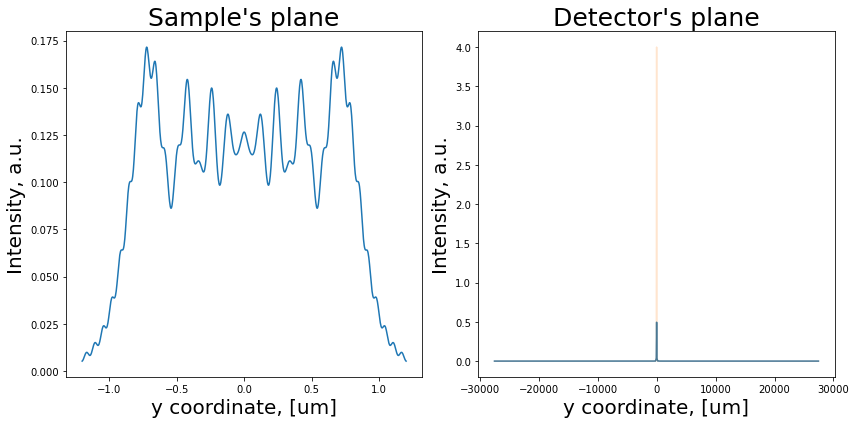

In [21]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(y_arr, np.abs(wf0_y)**2)
axes[1].plot(yy_arr, np.abs(wf1_y)**2)
axes[1].plot(yy_arr, (ap_y * np.sinc(np.pi * ap_y * yy_arr / wl / (det_dist + focus + defocus)))**2, alpha=0.2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('y coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

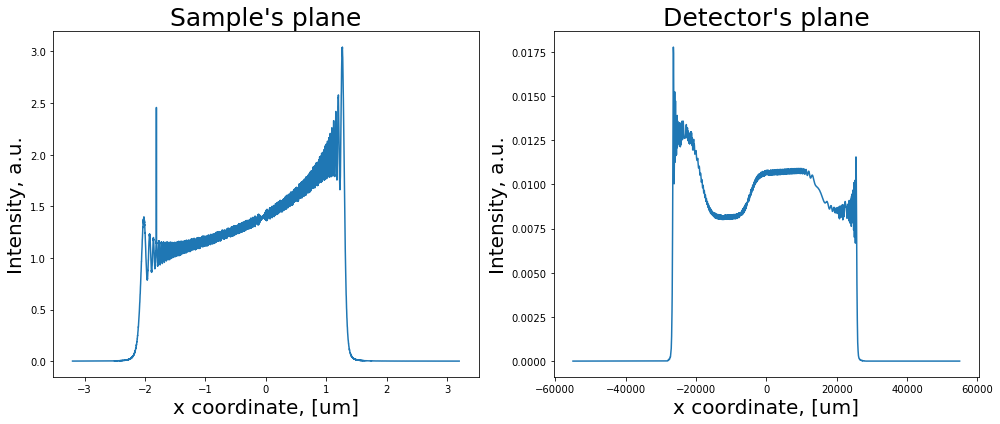

In [22]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_arr, np.abs(wf0_x)**2)
axes[1].plot(xx_arr, np.abs(wf1_x[0])**2)
axes[0].set_title("Sample's plane", fontsize=25)
axes[1].set_title("Detector's plane", fontsize=25)
for ax in axes:
    ax.set_xlabel('x coordinate, [um]', fontsize=20)
    ax.set_ylabel('Intensity, a.u.', fontsize=20)
plt.tight_layout(w_pad=1.)
plt.show()
# plt.savefig('figures/beam_x.pdf')

In [39]:
sigma = th_s * det_dist
sx_arr = pix_size * np.arange(-np.ceil(4 * sigma / pix_size), np.ceil(4 * sigma / pix_size) + 1)
s_arr = np.exp(-sx_arr**2 / 2 / sigma**2)
s_arr /= s_arr.sum()
print(sigma / pix_size)

2.909090909090909


In [43]:
det_c = 1 / wl**2 / (focus + defocus) / det_dist
i0 = p0 / ap_x / ap_y
data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)
beam_span = np.tan(th_lim) * (det_dist + defocus)
x_roi = np.clip((beam_span - xx_arr.min()) // pix_size, 0, fs_size).astype(np.int)
roi = (data.shape[1] // 2, data.shape[1] // 2 + 1, x_roi[0], x_roi[1])
ptych = data[:, :, roi[2]:roi[3]].sum(axis=1)
mask = np.ones((data.shape[1], data.shape[2]), dtype=np.uint8)
whitefield = make_whitefield(data, mask)
print(data.shape, np.mean(ptych[..., 20:-20]), np.std(ptych[..., 20:-20]),
      np.std(ptych[..., 20:-20]) / np.sqrt(np.mean(ptych[..., 20:-20])))

(200, 1, 2000) 36.82865628604383 7.118241024850058 1.1729506826926777


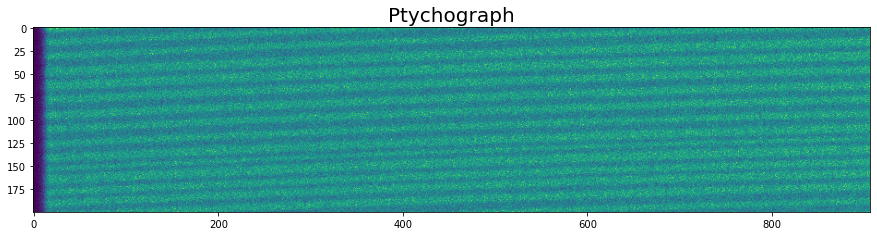

In [44]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(ptych)
ax.set_title('Ptychograph', fontsize=20)
plt.show()

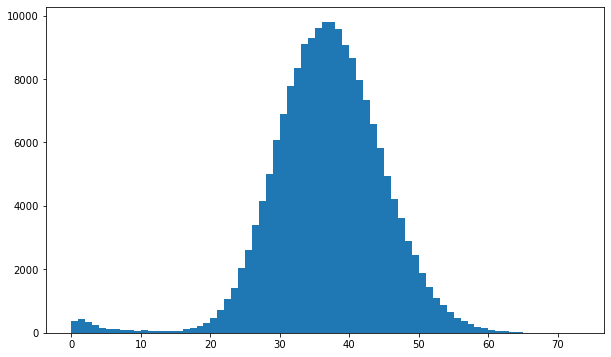

In [45]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ptych.ravel(), min(int(ptych.max() - ptych.min()), 100))
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [9]:
x_arr = np.linspace(-0.75, 0.75, 512)[:, None]
y_arr = np.linspace(-1.5, 1.5, 512)[None, :]
z_arr = 0.3 * x_arr + np.exp(-6 * x_arr**2 - 6 * (y_arr - 0.7)**2) - \
        np.exp(-3 * x_arr**2 - 6 * (y_arr + 0.7)**2)
z_pad = np.pad(z_arr, ((0, 0), (z_arr.shape[1], 0)), mode='symmetric')
z_pad = np.pad(z_pad, ((z_arr.shape[0], 0), (0, 0)), mode='symmetric')
sx_arr = np.gradient(z_arr, axis=0)
sy_arr = np.gradient(z_arr, axis=1)

In [12]:
u = rst_res.pixel_map
u0 = rst_obj.pixel_map
sx_arr = ((u - u0)[0] - (u - u0)[0].mean())
sy_arr = ((u - u0)[1] - (u - u0)[1].mean())

%time phase_st = ct_integrate(sx_arr, sy_arr)
%time phase_cti = dev.ct_integrate(sx_arr, sy_arr)
print(phase_st.min(), phase_st.max())
print(phase_cti.min(), phase_cti.max())

CPU times: user 773 ms, sys: 8.67 ms, total: 782 ms
Wall time: 783 ms
CPU times: user 66.2 ms, sys: 1.97 ms, total: 68.2 ms
Wall time: 67.6 ms
-434.10308929864084 184.96397905494402
-434.1030892986407 184.96397905494402


In [13]:
error_cti = np.mean((np.gradient(phase_cti, axis=0) - sx_arr)**2 + (np.gradient(phase_cti, axis=1) - sy_arr)**2)
error_st = np.mean((np.gradient(phase_st, axis=0) - sx_arr)**2 + (np.gradient(phase_st, axis=1) - sy_arr)**2)
print(error_cti, error_st)

0.8807470561880254 0.8807470561880257


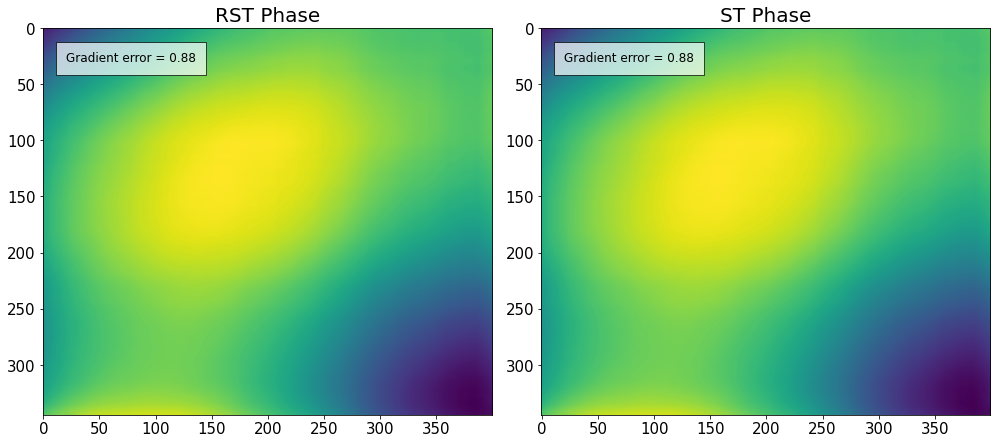

In [14]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(phase_cti)
axes[0].text(20, 30, 'Gradient error = {:.2f}'.format(error_cti), fontsize=12,
             bbox={'facecolor': 'white', 'pad': 10, 'alpha': 0.7})
axes[0].set_title('RST Phase', fontsize=20)
axes[1].imshow(phase_st)
axes[1].text(20, 30, 'Gradient error = {:.2f}'.format(error_st), fontsize=12,
             bbox={'facecolor': 'white', 'pad': 10, 'alpha': 0.7})
axes[1].set_title('ST Phase', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/rst_phase.pdf')

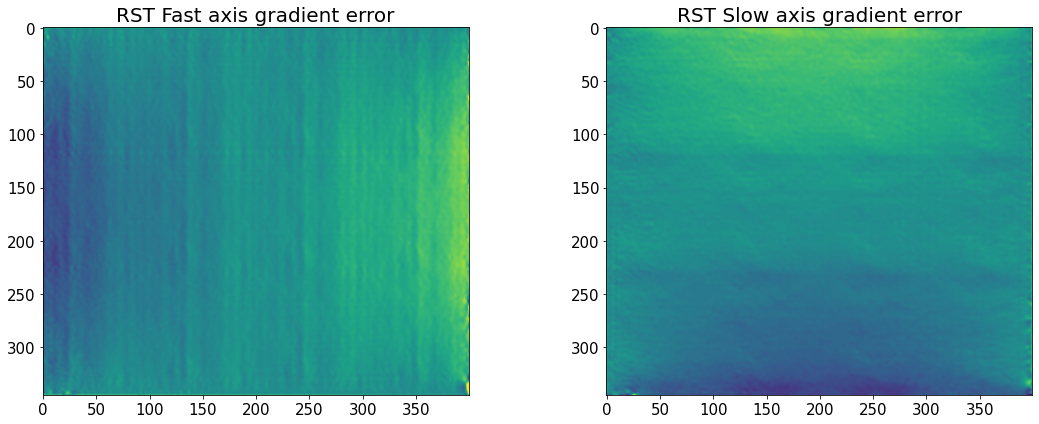

In [15]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((np.gradient(phase_cti, axis=0) - sx_arr), vmin=-3, vmax=3)
axes[0].set_title('RST Fast axis gradient error', fontsize=20)
axes[1].imshow((np.gradient(phase_cti, axis=1) - sy_arr), vmin=-3, vmax=3)
axes[1].set_title('RST Slow axis gradient error', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
# plt.show()
plt.savefig('figures/dev_angles_error_rst.pdf')

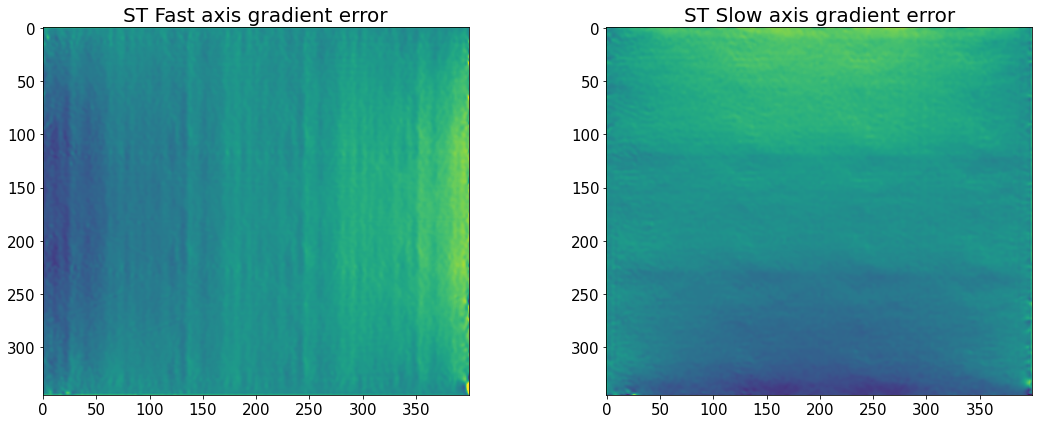

In [16]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((np.gradient(phase_st, axis=0) - sx_arr), vmin=-3, vmax=3)
axes[0].set_title('ST Fast axis gradient error', fontsize=20)
axes[1].imshow((np.gradient(phase_st, axis=1) - sy_arr), vmin=-3, vmax=3)
axes[1].set_title('ST Slow axis gradient error', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.show()
plt.savefig('figures/dev_angles_error_st.pdf')

In [44]:
dir_path = 'results/test_ideal'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data0 = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1370])
rst_obj0 = rst_data0.get_st()
rst_res0, errors = rst_obj0.iter_update(sw_fs=10, ls_pm=3., ls_ri=10, verbose=True, n_iter=10)

rst_data0.update_phase(rst_res0)
fit_res = rst_data0.fit_phase()
fit_res['ph_fit'][0] * 1e-9

Iteration No. 0: Total MSE = 0.128
Iteration No. 1: Total MSE = 0.084
Iteration No. 2: Total MSE = 0.052
Iteration No. 3: Total MSE = 0.037
Iteration No. 4: Total MSE = 0.031
Iteration No. 5: Total MSE = 0.029


-0.0525364884346889

In [37]:
dir_path = 'results/test'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1370])
rst_data = rst_data.make_whitefield()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(sw_fs=10, ls_pm=3, ls_ri=5, verbose=True, n_iter=10)

rst_data.update_phase(rst_res)
fit_res = rst_data.fit_phase()
fit_res['ph_fit'][0] * 1e-9

Iteration No. 0: Total MSE = 0.138
Iteration No. 1: Total MSE = 0.095
Iteration No. 2: Total MSE = 0.064
Iteration No. 3: Total MSE = 0.049
Iteration No. 4: Total MSE = 0.042
Iteration No. 5: Total MSE = 0.039


-0.05238130434555541

In [5]:
dir_path = 'results/sim_results'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=(0, 1, 520, 1450))
rst_data = rst_data.make_whitefield()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(sw_fs=10, ls_pm=2.5, ls_ri=5, verbose=True, n_iter=10)

rst_data.update_phase(rst_res)
fit = rst_data.fit_phase(axis=1, max_order=2)
fit['ph_fit'][0] * 1e-9 # alpha in the simulation

Iteration No. 0: Total MSE = 0.257
Iteration No. 1: Total MSE = 0.219
Iteration No. 2: Total MSE = 0.180
Iteration No. 3: Total MSE = 0.153
Iteration No. 4: Total MSE = 0.134
Iteration No. 5: Total MSE = 0.123
Iteration No. 6: Total MSE = 0.117
Iteration No. 7: Total MSE = 0.114
Iteration No. 8: Total MSE = 0.112


-0.050667038898925924

In [15]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'bnprd_var', 'bprd_var', 'ct_integrate', 'gaussian_filter', 'init_newton', 'krig_data', 'make_frames', 'make_reference', 'mse_2d', 'np', 'pixel_translations', 'st', 'st_update', 'str_update', 'subpixel_refinement_1d', 'subpixel_refinement_2d', 'total_mse', 'update_pixel_map_gs', 'upm_newton_1d']


In [16]:
W = rst_data.whitefield
I_n = rst_data.data
dij = rst_data.translations
basis = rst_data.basis_vectors
x_ps = rst_data.x_pixel_size
y_ps = rst_data.y_pixel_size
z = rst_data.distance
df = rst_data.defocus_fs
roi = rst_data.roi


st_res = dev.st_update(I_n, W, dij, basis, x_ps, y_ps, z, df, sw_ss=0, sw_fs=10, ls=5, n_iter=10, roi=roi)

TypeError: calc_error() got an unexpected keyword argument 'roi'

ValueError: operands could not be broadcast together with shapes (2,1,2000) (2,1,930) 

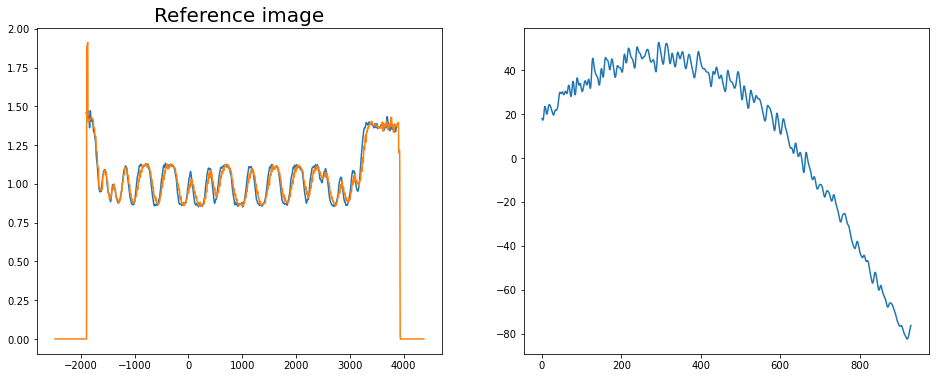

In [14]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(np.arange(rst_res.reference_image.shape[1]) - rst_res.m0,
             rst_res.reference_image[0])
axes[0].plot(np.arange(st_res['I0'].shape[1]) - st_res['m0'], st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot((rst_res.pixel_map - rst_obj.pixel_map)[1, 0])
axes[1].plot((st_res['u'][] - rst_obj.pixel_map)[1, 0])
axes[1].set_title('Pixel mapping', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
    ax.set_xlabel('Fast axis, pixels', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_res.png', dpi=300)

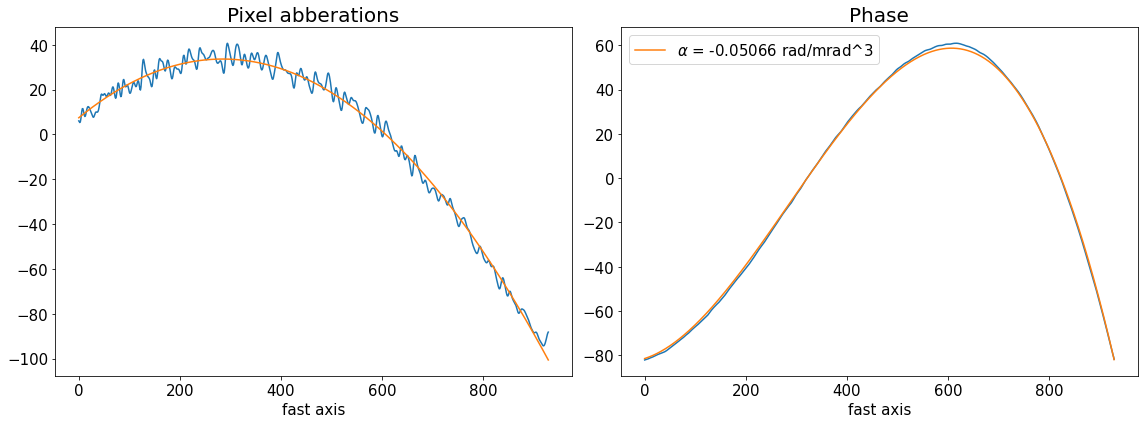

In [17]:
%matplotlib inline
fit_obj = rst_data.get_fit(axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit['pixels'], rst_data.get('pixel_abberations')[1, 0])
axes[0].plot(fit['pixels'], fit_obj.model(fit['pix_fit'], fit['pixels']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit['pixels'], rst_data.get('phase')[0])
axes[1].plot(fit['pixels'], fit_obj.phase_model(fit['ph_fit'], fit['pixels']),
             label=r'$\alpha$ = {:.5f} rad/mrad^3'.format(fit['ph_fit'][0] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
axes[1].legend(fontsize=15)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('fast axis', fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_fits.png')

In [5]:
loader = rst.loader()
rst_data = loader.load('results/exp/diatom.cxi', defocus=2.23e-3,
                       roi=(75, 420, 55, 455), good_frames=np.arange(1, 121))
rst_data = rst_data.make_mask(method='perc-bad')

rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(sw_fs=5, sw_ss=5, ls_pm=1.5, ls_ri=0.7, verbose=True, n_iter=10)

Iteration No. 0: Total MSE = 0.798
Iteration No. 1: Total MSE = 0.625
Iteration No. 2: Total MSE = 0.261
Iteration No. 3: Total MSE = 0.200
Iteration No. 4: Total MSE = 0.206


In [7]:
with h5py.File('results/diatom_proc.cxi', 'w') as cxi_file:
    rst_data.write_cxi(cxi_file)

In [20]:
rst_data.update_phase(rst_res)
fit_ss = rst_data.fit_phase(axis=0, max_order=3)
fit_fs = rst_data.fit_phase(axis=1, max_order=3)

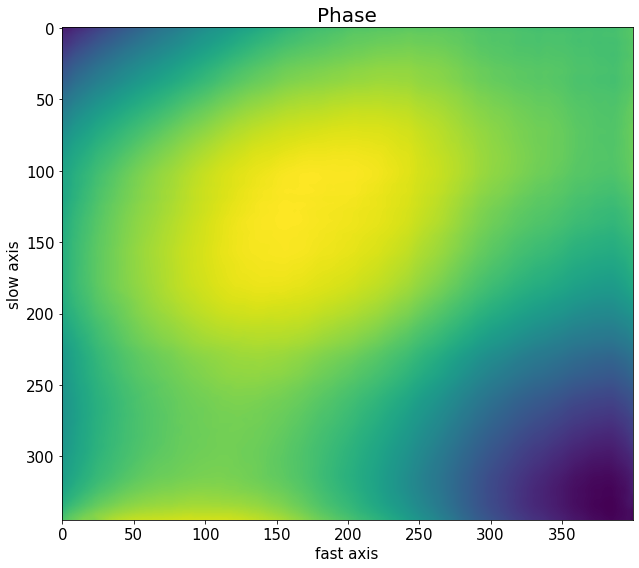

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rst_data.get('phase'))
ax.set_title('Phase', fontsize=20)
ax.set_xlabel('fast axis', fontsize=15)
ax.set_ylabel('slow axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/diatom_phase.png', dpi=300)

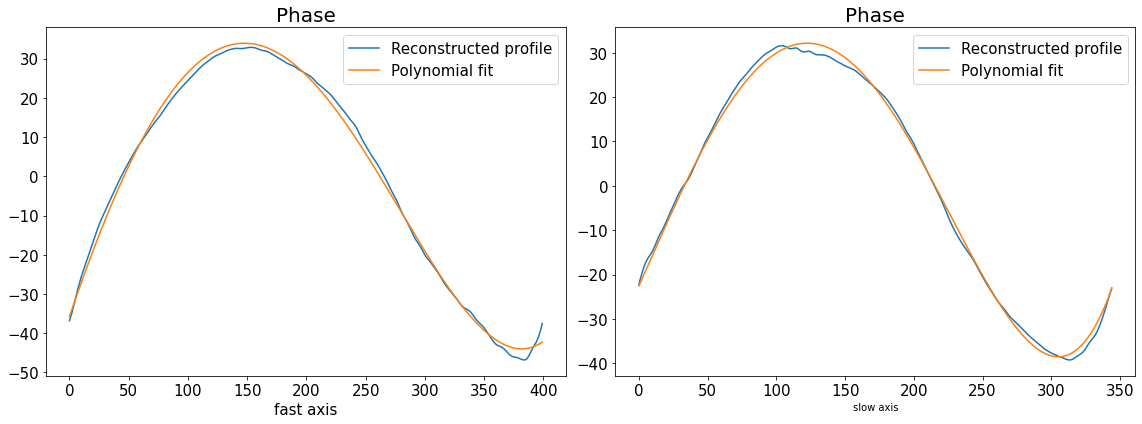

In [23]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(rst_data.get('phase').mean(axis=0), label='Reconstructed profile')
axes[0].plot(rst_data.get_fit(axis=1).phase_model(fit_fs['ph_fit'], fit_fs['pixels']),
             label='Polynomial fit')
axes[0].set_xlabel('fast axis', fontsize=15)
axes[1].plot(rst_data.get('phase').mean(axis=1), label='Reconstructed profile')
axes[1].plot(rst_data.get_fit(axis=0).phase_model(fit_ss['ph_fit'], fit_ss['pixels']),
             label='Polynomial fit')
axes[1].set_xlabel('slow axis')
for ax in axes:
    ax.set_title('Phase', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/phase_fit.png', dpi=300)

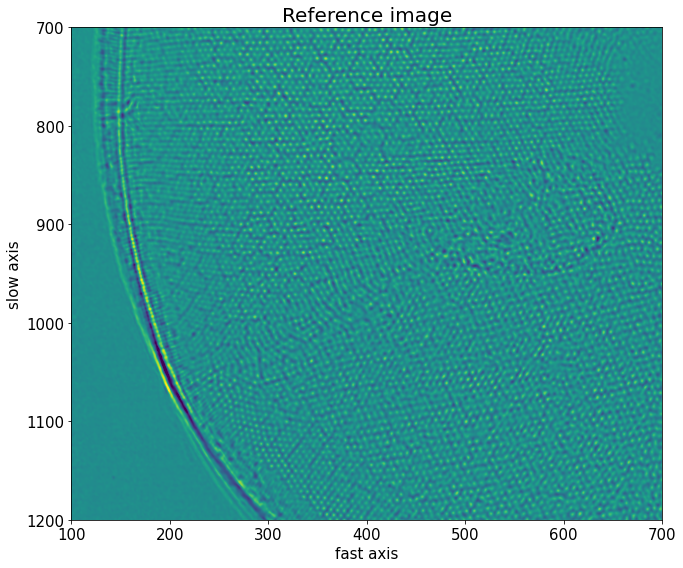

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rst_res.reference_image[700:1200, 100:700], vmin=0.7, vmax=1.3, extent=[100, 700, 1200, 700])
ax.set_title('Reference image', fontsize=20)
ax.set_xlabel('fast axis', fontsize=15)
ax.set_ylabel('slow axis', fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/diatom_image.png', dpi=300)

In [14]:
defoci = np.linspace(2e-3, 3e-3, 50)
sweep_scan = rst_data.defocus_sweep(defoci, ls_ri=0.7)

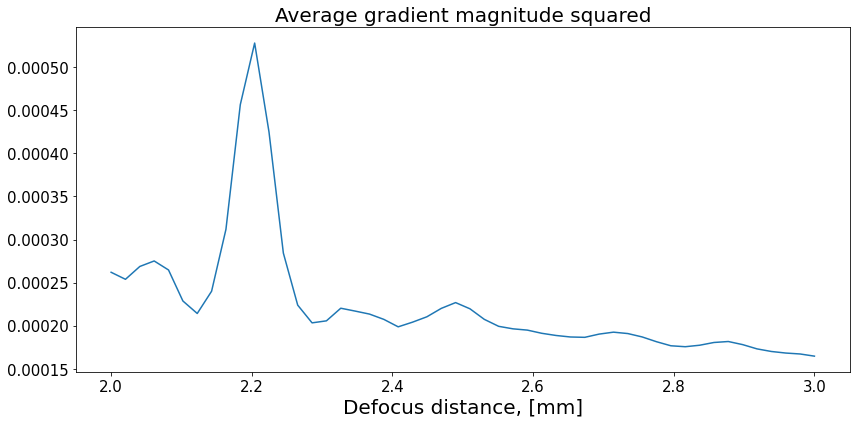

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(defoci * 1e3, sweep_scan)
ax.set_xlabel('Defocus distance, [mm]', fontsize=20)
ax.set_title('Average gradient magnitude squared', fontsize=20)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('docs/figures/sweep_scan.png', dpi=300)
# plt.show()

In [6]:
from scipy.ndimage import gaussian_gradient_magnitude
defoci = np.linspace(2e-3, 3e-3, 20)
ls_ri = 0.7
ri_list, gravg = [], []

for defocus in defoci:
    data = rst_data.update_defocus(defocus)
    st_obj = data.get_st()
    ri = st_obj.update_reference(ls_ri=0.7).reference_image
    ri_list.append(ri)
    gravg.append((gaussian_gradient_magnitude(ri, sigma=0.7)**2).mean())

In [5]:
loader = rst.loader()
rst_data = loader.load('results/exp/MLL_00223.cxi', defocus_fs=2.9163e-4, defocus_ss=3.9318e-4,
                       roi=(35, 445, 265, 695))
rst_data = rst_data.make_mask(method='perc-bad')
rst_data = rst_data.update_defocus(defocus_fs=2.9318e-4, defocus_ss=2.9163e-4)

rst_obj = rst_data.get_st()
# rst_res, errors = rst_obj.iter_update([15, 15], ls_pm=1.5, ls_ri=0.7, verbose=True, n_iter=5)

In [20]:
W = rst_data.get('whitefield')
I_n = rst_data.get('data')
u0 = rst_data.get('pixel_map')
basis = rst_data.get('basis_vectors')
z = rst_data.get('distance')
x_ps = rst_data.get('x_pixel_size')
y_ps = rst_data.get('y_pixel_size')
wl = rst_data.get('wavelength')
dij = rst_data.get('translations')
df_ss = rst_data.get('defocus_ss')
df_fs = rst_data.get('defocus_fs')

M = ((I_n - np.median(I_n))**2 < np.percentile((I_n - np.median(I_n))**2, 99.99)).all(axis=0)
W *= M; I_n *= M

sw_max = 10
dij_pix = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                y_ps, z, df_fs, df_ss, verbose=False)[1]
%time I0_st, n0_st, m0_st = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)
# %time u_st = st.update_pixel_map(I_n.astype(np.float32), M, W, I0_st, \
#                                  u0, n0_st, m0_st, dij_pix, subpixel=True, \
#                                  search_window=[2 * sw_max, 2 * sw_max], \
#                                  fill_bad_pix=True, integrate=False, \
#                                  quadratic_refinement=True, verbose=False)[0]

CPU times: user 5.05 s, sys: 305 ms, total: 5.36 s
Wall time: 5.26 s


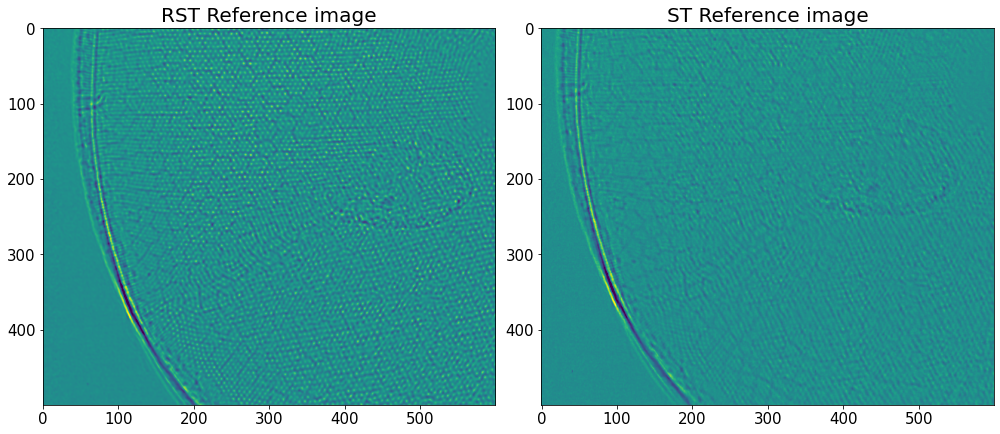

In [64]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(I0[700:1200, 100:700], vmin=0.7, vmax=1.3)
axes[0].set_title('RST Reference image', fontsize=20)
axes[1].imshow(I0_st[700:1200, 100:700], vmin=0.7, vmax=1.3)
axes[1].set_title('ST Reference image', fontsize=20)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/reference_image_2d.pdf')

In [17]:
sw_max = 15
j, k = 116, 98
ls_ri = 0.7
ls_pm = 1.5

I0_rst, n0_rst, m0_rst = make_reference(I_n, W, u0, di, dj, ls_ri, 0, 0)
u = upm_search(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst, sw_max, sw_max, ls_pm)

In [34]:
ls_ri = 0.7
ls_pm = 1.5
c_ri, c_pm = 0.5, 0.5
u_res = u0.copy()
u_res += c_pm * gaussian_filter(u - u0, (0, ls_pm, ls_pm))
I0_res = I0.copy()
ss_roi = np.clip([n0 - n0_rst, I0_rst.shape[0] + n0 - n0_rst], 0, I0_res.shape[0]) - n0
fs_roi = np.clip([m0 - m0_rst, I0_rst.shape[1] + m0 - m0_rst], 0, I0_res.shape[1]) - m0
ss_s0, fs_s0 = slice(*(ss_roi + n0)), slice(*(fs_roi + m0))
ss_s1, fs_s1 = slice(*(ss_roi + n0_rst)), slice(*(fs_roi + m0_rst))
I0_res[ss_s0, fs_s0] += c_ri * gaussian_filter(I0_rst[ss_s1, fs_s1] - I0_res[ss_s0, fs_s0],
                                               (ls_ri, ls_ri))

In [35]:
print(dev.total_mse(I_n, W, I0, u0, di - n0, dj - m0, ls_ri))
print(dev.total_mse(I_n, W, I0_rst, u, di - n0_rst, dj - m0_rst, ls_ri))
print(dev.total_mse(I_n, W, I0_res, u_res, di - n0, dj - m0, ls_ri))

0.2443718430318201
0.2264406241981858
0.24601415472295715


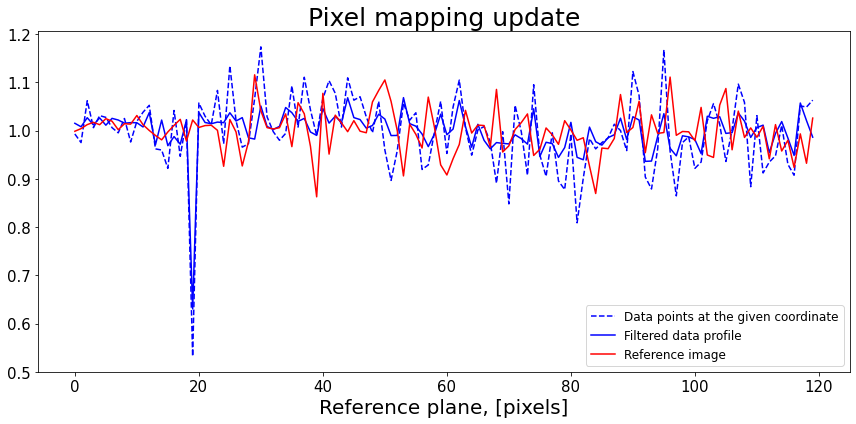

In [59]:
ffs = u0[1] - dj[:, None, None] + m0
sfs = u0[0] - di[:, None, None] + n0

%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot((I_n[:, j, k] / W[j, k]).ravel(), 'b--',
        label='Data points at the given coordinate')
ax.plot(dev.krig_data(I_n, W, u0, j, k, 1.4)[:-1], 'b',
        label='Filtered data profile')
ax.plot(I0_rst[sfs[:, j, k].astype(int), ffs[:, j, k].astype(int)].ravel(), 'r',
        label='Reference image')
ax.set_xlabel('Reference plane, [pixels]', fontsize=20)
ax.set_title('Pixel mapping update', fontsize=25)
ax.legend(fontsize=12)
ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_update.pdf')

In [16]:
mse, mse_var = dev.mse_2d(I_n, W, I0_rst, u0, di - n0, dj - m0, sw_max, sw_max, ls_pm)
l1 = dev.init_stars(I_n, W, I0_rst, u0, di - n0, dj - m0, sw_max, sw_max, ls_pm)
mse.shape, mse_var.shape, l1.shape

((350, 410, 40, 40), (350, 410, 40, 40), (350, 410))

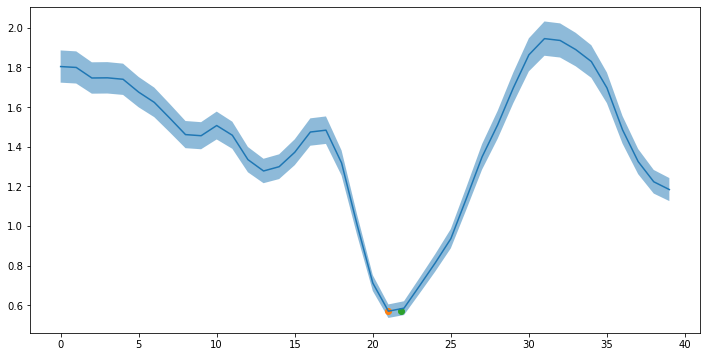

In [26]:
j, k = 110, 250
ss_min = int(u_np[0, j, k] + sw_max)
fs_min = int(u_np[1, j, k] + sw_max)
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(np.arange(2 * sw_max), mse[j, k, :, fs_min] + np.sqrt(mse_var[j, k, :, fs_min]),
                mse[j, k, :, fs_min] - np.sqrt(mse_var[j, k, :, fs_min]), alpha=0.5)
ax.plot(mse[j, k, :, fs_min])
ax.scatter(ss_min, mse[j, k, ss_min, fs_min])
ax.scatter(ss_min + du_s[j, k], mse[j, k, ss_min, fs_min])
plt.show()

In [156]:
sw_max = 20
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
ls_ri = 0.7
ls_pm = 1.5

%time I0_rst, n0_rst, m0_rst = make_reference(I_n, W, u0, di, dj, \
                                              ls_ri, wfs=0)
%time u_rst = dev.upm_search(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst, \
                             sw_max, sw_max, ls_pm)

CPU times: user 21.6 s, sys: 63.2 ms, total: 21.7 s
Wall time: 1.91 s
CPU times: user 13min 22s, sys: 838 ms, total: 13min 23s
Wall time: 1min 9s


In [157]:
sw_max = 10
dij_pix = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                y_ps, z, df, verbose=False)[1]
%time I0_st, n0_st, m0_st = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)
%time u_st = st.update_pixel_map(I_n.astype(np.float32), M, W, I0_st, \
                                 u0, n0_st, m0_st, dij_pix, subpixel=True, \
                                 search_window=[2 * sw_max, 2 * sw_max], \
                                 fill_bad_pix=True, integrate=False, \
                                 quadratic_refinement=True, verbose=False)[0]

CPU times: user 3.56 s, sys: 509 ms, total: 4.07 s
Wall time: 2.25 s
-10 10
-10 10


updating pixel map: 6.96e-01: 100%|██████████| 1435/1435 [04:18<00:00,  5.55it/s]


quadratic_refinement: True
CPU times: user 9min 42s, sys: 5min 57s, total: 15min 40s
Wall time: 4min 21s


In [158]:
print(dev.total_mse(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst, 1.5))
print(dev.total_mse(I_n, W, I0_rst, u_rst, di - n0_rst, dj - m0_rst, 1.5))

0.8383653921785708
0.39629493914876224


In [159]:
print(dev.total_mse(I_n, W, I0_rst, u0, di - n0_st, dj - m0_st, 1.5))
print(dev.total_mse(I_n, W, I0_rst, u_st, di - n0_st, dj - m0_st, 1.5))

0.7737409180275016
0.4036527191392844


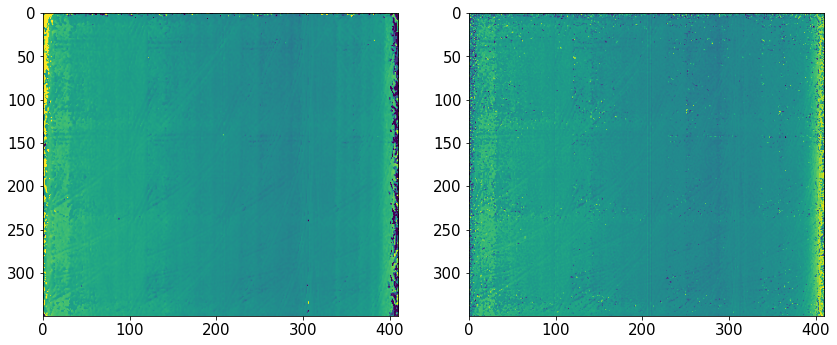

In [160]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow((u_rst - u0)[1], vmin=-10, vmax=10)
axes[1].imshow((u_st - u0)[1], vmin=-10, vmax=10)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.show()

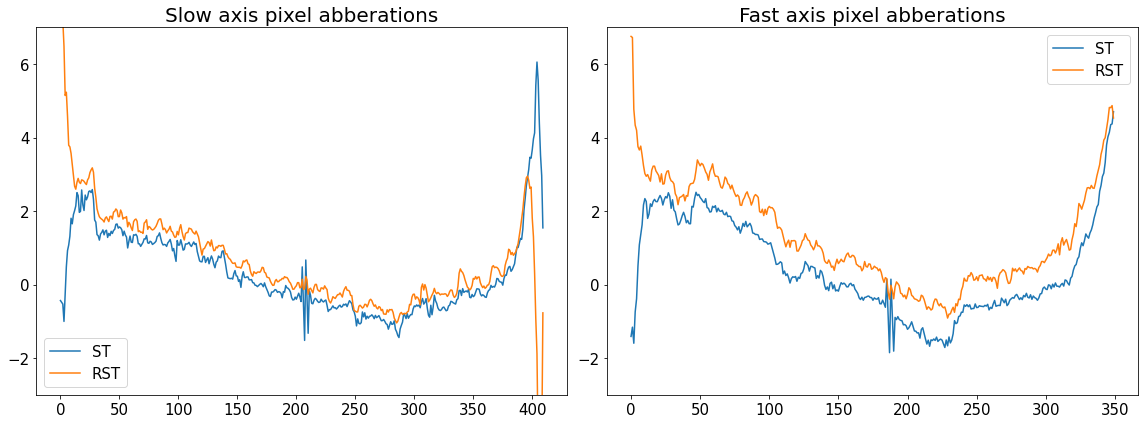

In [161]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((u_st - u0)[1].mean(axis=0), label='ST')
axes[0].plot((u_rst - u0)[1].mean(axis=0), label='RST')
axes[0].set_title('Slow axis pixel abberations', fontsize=20)
axes[1].plot((u_st - u0)[0].mean(axis=1), label='ST')
axes[1].plot((u_rst - u0)[0].mean(axis=1), label='RST')
axes[1].set_title('Fast axis pixel abberations', fontsize=20)
for ax in axes:
    ax.set_ylim(-3, 7)
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/pm_2d.pdf')

# Simulation results

In [31]:
data_dir = 'results/test'
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi = cxi_file['/speckle_tracking/roi'][...]
    I_n = cxi_file['/entry_1/data_1/data'][:, :, roi[2]:roi[3]].sum(axis=1)[:, None]
    M = cxi_file['/speckle_tracking/mask'][roi[0]:roi[1], roi[2]:roi[3]]
    W = cxi_file['/speckle_tracking/whitefield'][roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df = cxi_file['/speckle_tracking/defocus'][...]

di, dj = pixel_translations(basis, dij, df, z)
I_n, W = I_n.astype(np.float64), W.astype(np.float64)
I_n.shape[-1], (dij[0] - dij[1]), basis[0]

(728,
 array([1.e-07, 0.e+00, 0.e+00]),
 array([[ 0.0e+00, -5.5e-05,  0.0e+00],
        [ 5.5e-05,  0.0e+00,  0.0e+00]]))

In [67]:
df_arr = np.linspace(0.7, 1.3) * df
defocus = np.array([defocus_ss, defocus_fs]) * np.ones((df_arr.size, 2))
defocus[:, (1, )] = df_arr[:, None]
list(1)

TypeError: 'int' object is not iterable

In [41]:
dij_pix = (dij[:, None] * basis).sum(axis=-1)
dij_pix /= (basis**2).sum(axis=-1) * np.array([defocus_ss, defocus_fs]) / z

In [111]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, 20., 0, 0, return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

7.554180242512434 30.02999999999999 728
3.1681538342778946e-06


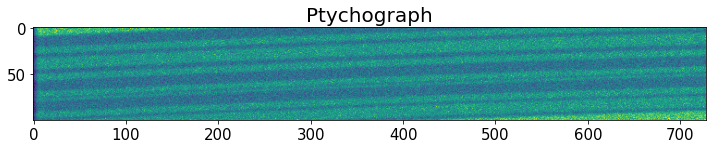

In [112]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [66]:
params = st_sim.parameters()

fx = params.ap_x / 2 / params.focus
z_bar = params.defocus * params.det_dist / (params.defocus + params.det_dist)
th_max = abs(params.wl / 2 / np.pi * params.alpha * 3e9 * fx**2 / (params.defocus + z_bar))
sw_max = max(int(2 * th_max / params.pix_size * params.det_dist), 10)
print(sw_max, th_max)

28 0.00038678518249739865


In [71]:
#---------------------------
# Intialise
#---------------------------
u0, dij_pix, res = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                         y_ps, z, df, verbose=False)
I0, n0, m0 = st.make_object_map(I_n, M, W, dij_pix, u, subpixel=True, verbose=False)
u = st.update_pixel_map(I_n.astype(np.float32), M, W, I0, u0, n0, m0, dij_pix,
                        search_window=[1, 100], subpixel=True,
                        fill_bad_pix=True, integrate=False,
                        quadratic_refinement=True, verbose=False)[0]

updating pixel map: 6.64e-01:  50%|█████     | 4/8 [00:00<00:00, 34.59it/s]

0 1
-50 50


updating pixel map: 6.48e-01: 100%|██████████| 8/8 [00:00<00:00, 34.77it/s]


quadratic_refinement: True


In [73]:
st_res = st_update(I_n.astype(np.float32), W.astype(np.float32), dij, basis, x_ps, y_ps, z, df)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl)

updating pixel map: 6.64e-01:  50%|█████     | 4/8 [00:00<00:00, 30.34it/s]

0 1
-50 50


updating object map and translations: 6.40e+01:   2%|▏         | 2/100 [00:00<00:05, 16.89it/s]

quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


updating pixel map: 6.22e-01:  75%|███████▌  | 6/8 [00:00<00:00, 54.11it/s]

(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
0 1
-26 26


building object map:   0%|          | 0/100 [00:00<?, ?it/s]

quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


updating pixel map: 6.10e-01: 100%|██████████| 8/8 [00:00<00:00, 41.47it/s]

0 1
-37 37
quadratic_refinement: True



updating pixel map: 6.06e-01:   0%|          | 0/8 [00:00<?, ?it/s]

(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
0 1
-39 39


calculating errors:   0%|          | 0/100 [00:00<?, ?it/s]

quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


updating pixel map: 6.04e-01:  50%|█████     | 4/8 [00:00<00:00, 35.51it/s]

0 1
-39 39


updating object map and translations: 6.21e+01:   0%|          | 0/100 [00:00<?, ?it/s]


quadratic_refinement: True
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)
(3, 100) (3, 100) (3, 3)
(100,) (100,) (3, 100) (100,)


In [138]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, l_scale=7.5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var=20)

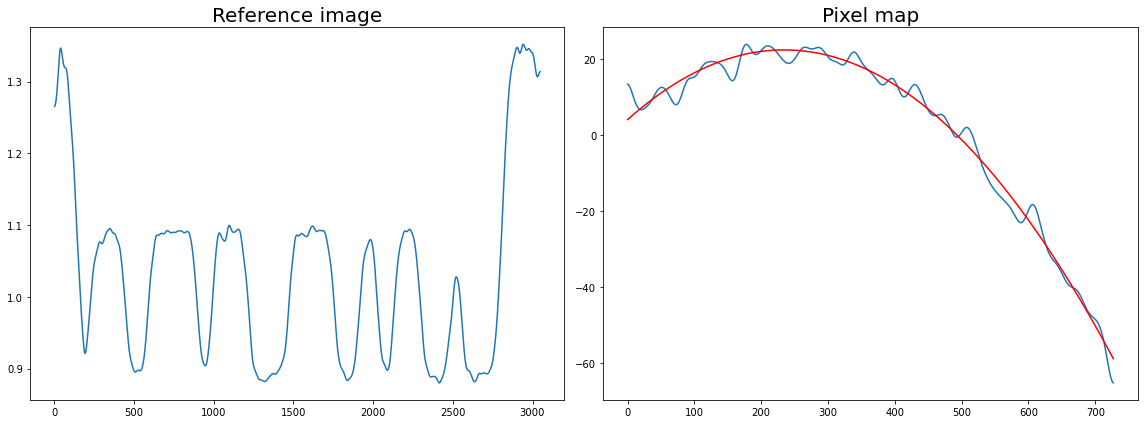

In [139]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

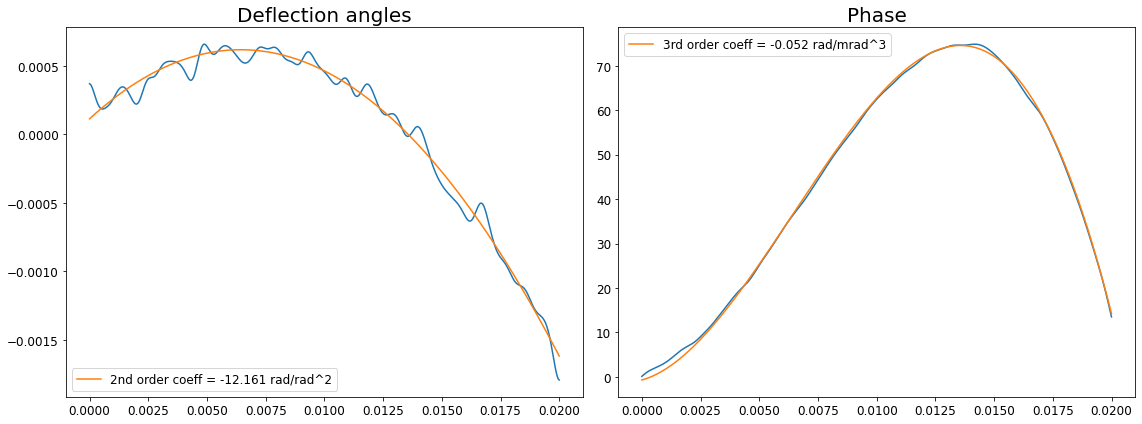

In [140]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(phr_res['theta'], phr_res['phase'])
axes[1].plot(phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_fits_5it.pdf')

# Experiment results

In [680]:
loader = rst.loader()
rst_data = loader.load('results/exp/diatom.cxi', defocus=2.23e-3,
                       roi=(70, 420, 50, 460),
                       good_frames=np.arange(1, 121))
rst_data = rst_data.make_mask(method='eiger-bad')

In [681]:
I_n = rst_data.get('data')
basis = rst_data.get('basis_vectors')
z = rst_data.get('distance')
x_ps = rst_data.get('x_pixel_size')
y_ps = rst_data.get('y_pixel_size')
wl = rst_data.get('wavelength')
dij = rst_data.get('translations')
W = rst_data.get('whitefield')
df = rst_data.get('defocus')

M = ((I_n - np.median(I_n))**2 < np.percentile((I_n - np.median(I_n))**2, 99.99)).all(axis=0)
W *= M; I_n *= M

In [663]:
sw_max = 20
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
ls_ri = 0.7
ls_pm = 1.5

%time I0_rst, n0_rst, m0_rst = make_reference(I_n, W, u0, di, dj,
                                              ls_ri, wfs=0)
%time u_rst = upm_search(I_n, W, I0_rst, u0, di - n0_rst, dj - m0_rst,
                         sw_max, sw_max, ls_pm)

CPU times: user 18.6 s, sys: 43.6 ms, total: 18.6 s
Wall time: 1.67 s
CPU times: user 10min 43s, sys: 755 ms, total: 10min 44s
Wall time: 56.2 s


In [664]:
sw_max = 20
dij_pix = st.generate_pixel_map(W.shape, dij, basis, x_ps,
                                y_ps, z, df, verbose=False)[1]
%time I0_st, n0_st, m0_st = st.make_object_map(I_n, M, W, dij_pix, u0, subpixel=True, verbose=False)
%time u_st = st.update_pixel_map(I_n.astype(np.float32), M, W, I0_st, \
                                 u0, n0_st, m0_st, dij_pix, \
                                 search_window=[2 * sw_max, 2 * sw_max],
                                 subpixel=True, \
                                 fill_bad_pix=True, integrate=False, \
                                 quadratic_refinement=True, verbose=False)[0]

CPU times: user 3.53 s, sys: 391 ms, total: 3.92 s
Wall time: 2.13 s
-10 10
-10 10


updating pixel map: 6.96e-01: 100%|██████████| 1435/1435 [03:42<00:00,  6.44it/s]


quadratic_refinement: True
CPU times: user 8min 50s, sys: 3min 50s, total: 12min 41s
Wall time: 3min 48s


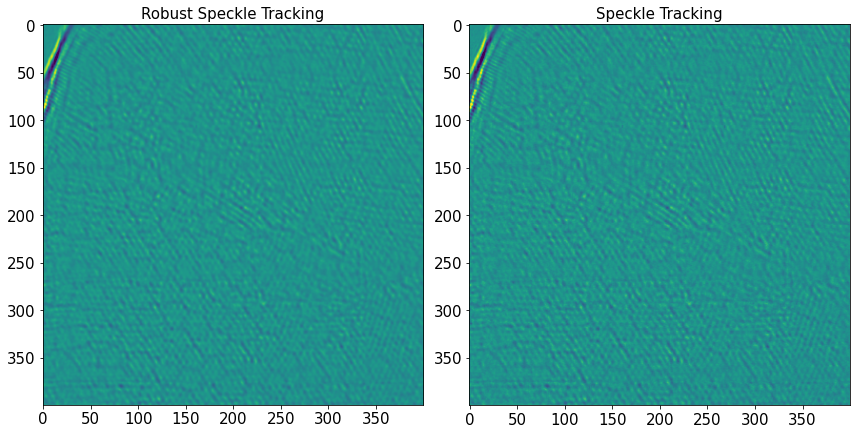

In [707]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(I0_rst[400:800, 200:600], vmin=0.7, vmax=1.3)
axes[0].set_title('Robust Speckle Tracking', fontsize=15)
axes[1].imshow(I0_st[400:800, 200:600], vmin=0.7, vmax=1.3)
axes[1].set_title('Speckle Tracking', fontsize=15)
for ax in axes:
    ax.tick_params(labelsize=15)
plt.tight_layout()
# plt.show()
# plt.savefig('figures/ri_2d.pdf')

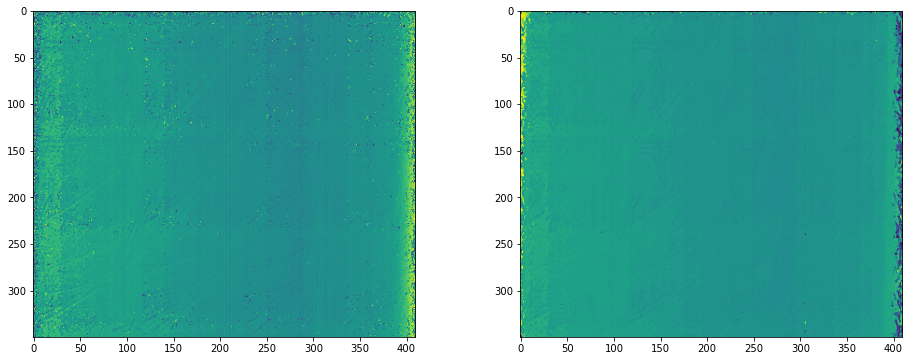

In [666]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow((u_st - u0)[1])
axes[1].imshow((u_rst - u0)[1])
plt.show()

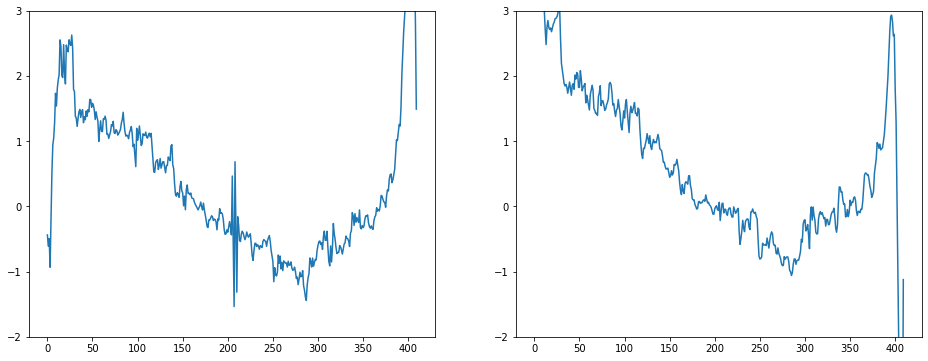

In [101]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot((u_st - u0)[1].mean(axis=0))
axes[1].plot((u_rst - u0)[1].mean(axis=0))
for ax in axes:
    ax.set_ylim(-2, 3)
plt.show()

In [163]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2008

loader = rst.loader()
rst_data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num], defocus=1.0e-4)
rst_data = rst_data.update_defocus()
rst_data = rst_data.make_whitefield()
rst_data = rst_data.make_pixel_map()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(300, ls_ri=15, ls_pm=5, verbose=True, n_iter=10, method='search')
rst_res.update_data()

Iteration No. 0: Total MSE = 0.179
Iteration No. 1: Total MSE = 0.088
Iteration No. 2: Total MSE = 0.084
Iteration No. 3: Total MSE = 0.084


In [167]:
ab_fit = rst_data.get_ab_fit()
fit_data = ab_fit.fit_pixel_ab(np.arange(rst_res.pixel_map.shape[-1]),
                               (rst_res.pixel_map - rst_obj.pixel_map)[1, 0],
                               max_order=3)

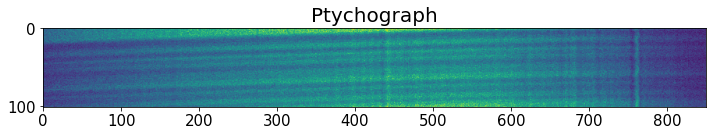

In [152]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(st_data.get('data')[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

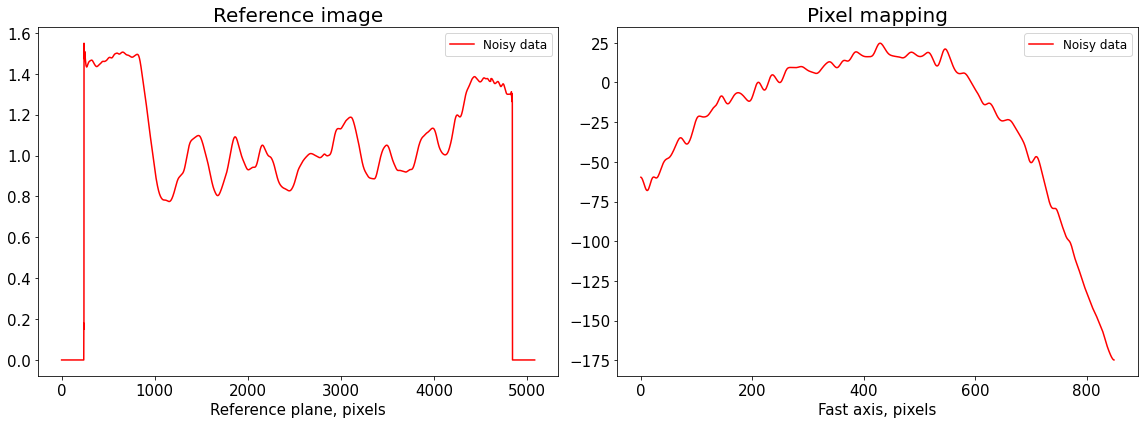

In [168]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(rst_res.reference_image[0], 'r', label='Noisy data')
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=15)
axes[1].plot((rst_res.pixel_map - rst_obj.pixel_map)[1, 0], 'r', label='Noisy data')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=15)
for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

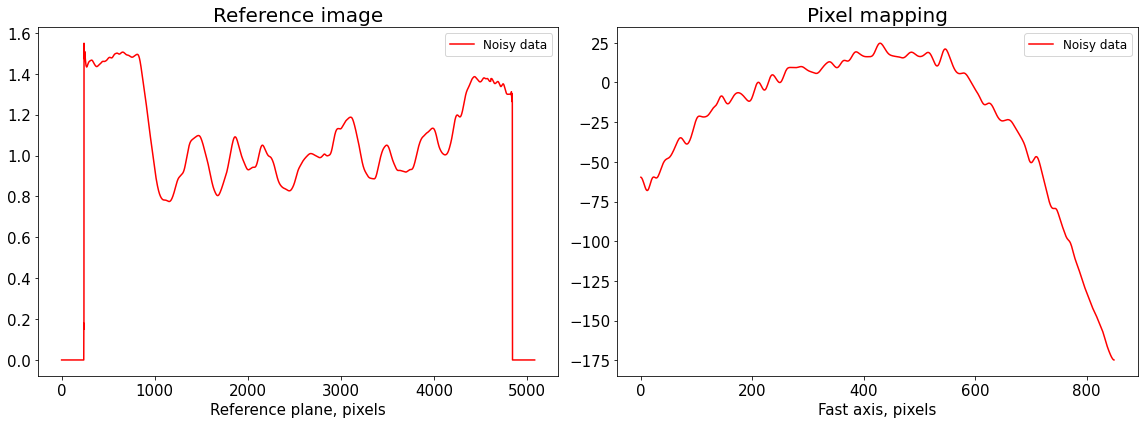

In [153]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0], 'r', label='Noisy data')
axes[0].set_title('Reference image', fontsize=20)
axes[0].set_xlabel('Reference plane, pixels', fontsize=15)
axes[1].plot((st_res.pixel_map - st_obj.pixel_map)[1, 0], 'r', label='Noisy data')
axes[1].set_title('Pixel mapping', fontsize=20)
axes[1].set_xlabel('Fast axis, pixels', fontsize=15)
for ax in axes:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/upm_results_5it.pdf')

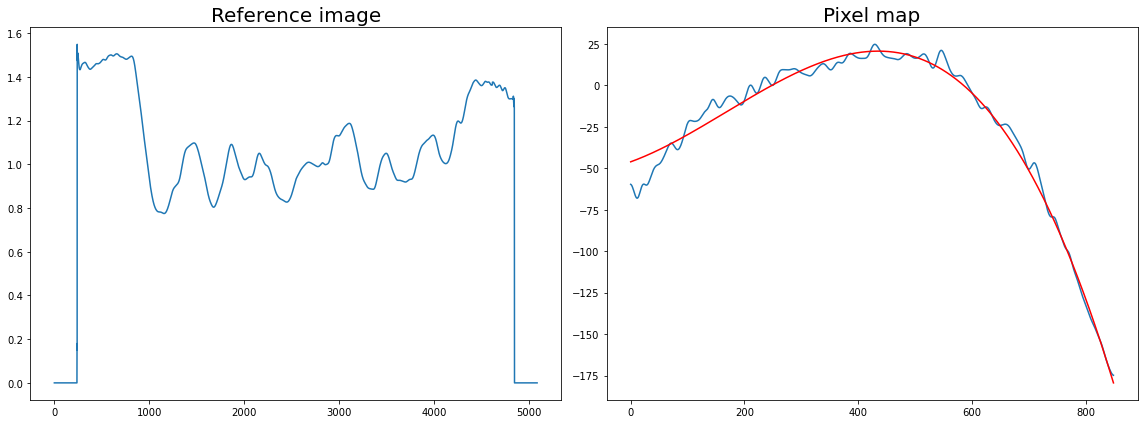

In [155]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(fit_data['pixels'], fit_data['pixel_ab'])
axes[1].plot(fit_data['pixels'], ab_fit.model(fit_data['fit'], fit_data['pixels']), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_2008.pdf')

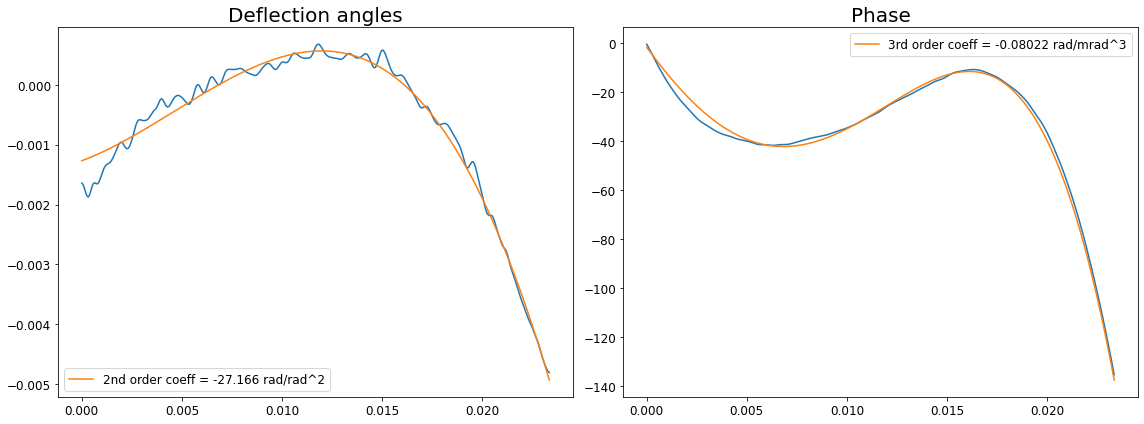

In [156]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_data['pixels'] * ab_fit.pix_ap, st_data.get('deviation_angles')[1, 0])
axes[0].plot(fit_data['pixels'] * ab_fit.pix_ap, ab_fit.angles_model(fit_data['fit'], fit_data['pixels']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ab_fit.to_ang_fit(fit_data['fit'])[-4]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(fit_data['pixels'] * ab_fit.pix_ap, st_data.get('phase')[0])
axes[1].plot(fit_data['pixels'] * ab_fit.pix_ap,
             ab_fit.phase_model(fit_data['fit'], fit_data['pixels'], st_data.get('phase')[0]),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(
                 ab_fit.to_ph_fit(fit_data['fit'], fit_data['pixels'], st_data.get('phase')[0])[-5] * 1e-9
             ))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_2008.pdf')

In [19]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
filename = 'Scan_{:d}.cxi'
exp_dir = 'results/exp'
scan_num = 2008

with h5py.File(os.path.join(exp_dir, filename.format(scan_num)), 'r') as cxi_file:
    roi = roi_dict[scan_num]
    I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]].sum(axis=1)[:, None]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

df = 1e-4
I_n = I_n.astype(np.float64)
M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
W = make_whitefield_st(I_n, M)
(dij[1] - dij[0]), I_n.shape[-1], np.mean(I_n), basis[0]

(array([0.0e+00, 9.6e-08, 0.0e+00]),
 850,
 72.90818870122307,
 array([[-5.5e-05,  0.0e+00,  0.0e+00],
        [ 0.0e+00, -5.5e-05,  0.0e+00]]))

In [20]:
I_n.shape

(101, 1, 850)

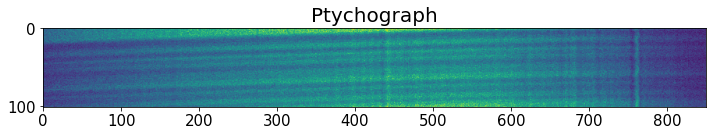

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [73]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, ls=20., return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

10.151162106893096 24.348958333599075 850
1.2507496085642653e-06


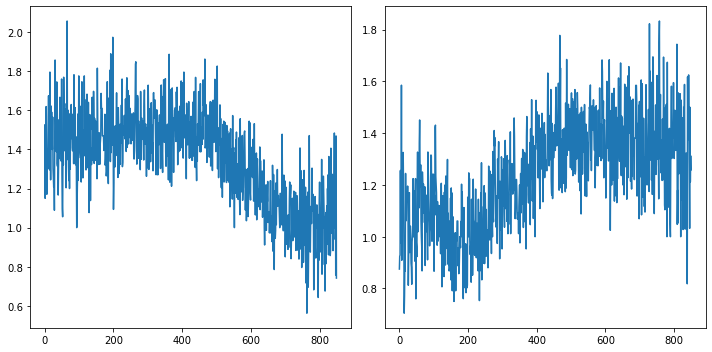

In [74]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(I_n[1, 0] / W[0] )
axes[1].plot(I_n[-1, 0] / W[0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [75]:
#---------------------------
# Intialise
#---------------------------
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
l_scale = 5.5
sw_max = 300

I0, n0, m0 = dev.make_reference(I_n, W, u0, di, dj, ls=l_scale, wfs=0)
I0_avg = dev.make_reference(I_n, W, u0, di, dj, ls=30, wfs=0)[0]
u = dev.upm_search(I_n, W, I0, u0, di - n0, dj - m0, 1, sw_max, l_scale)
# u = dev.upm_newton_1d(I_n, W, I0, u0, di, dj, sw_max, l_scale)
u = u0 + gaussian_filter(u - u0, (0, 0, l_scale))
print(I0.shape)

(1, 4484)


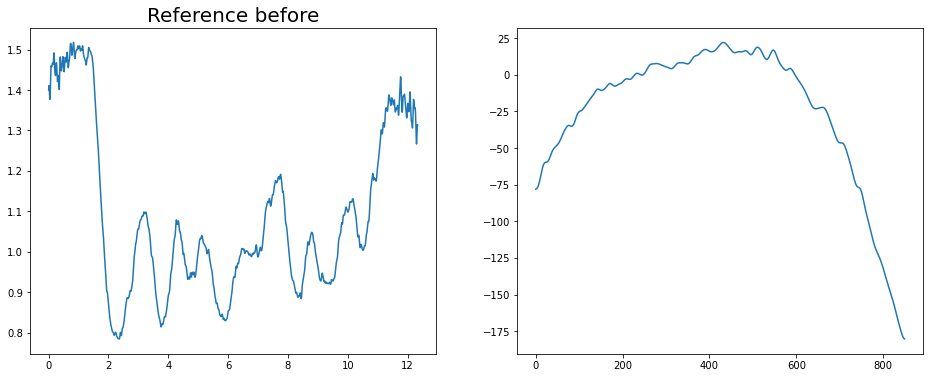

In [76]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(1e6 * np.arange(I0.size) * x_ps * df / z, I0[0])
axes[0].set_title('Reference before', fontsize=20)
axes[1].plot((u - u0)[1, 0])
plt.show()
# plt.savefig('figures/reference_1595.pdf')

In [176]:
st_res = st_update(I_n.astype(np.float32), W, dij, basis, x_ps, y_ps, z, df, u_max=300)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl, u_var)

updating object map and translations: 4.73e+01:   0%|          | 0/100 [00:00<?, ?it/s]


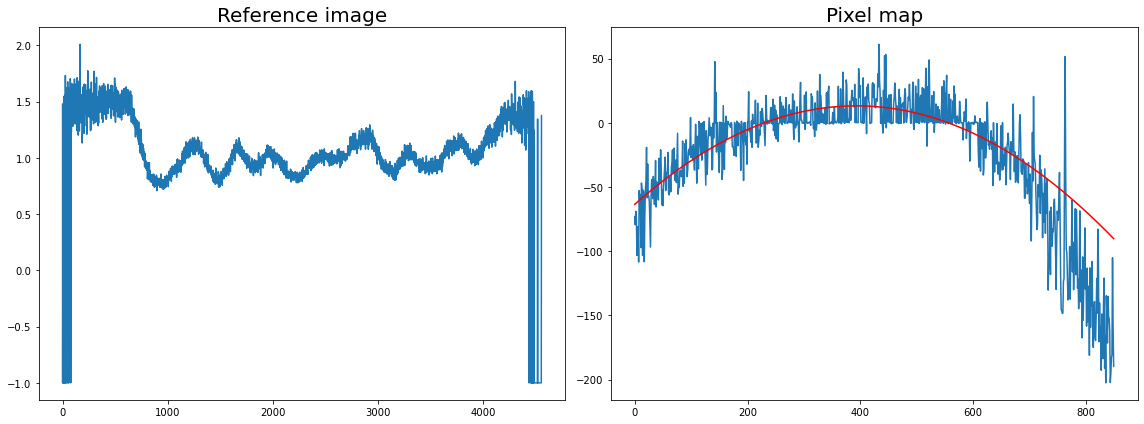

In [159]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_andrew_1727.pdf')

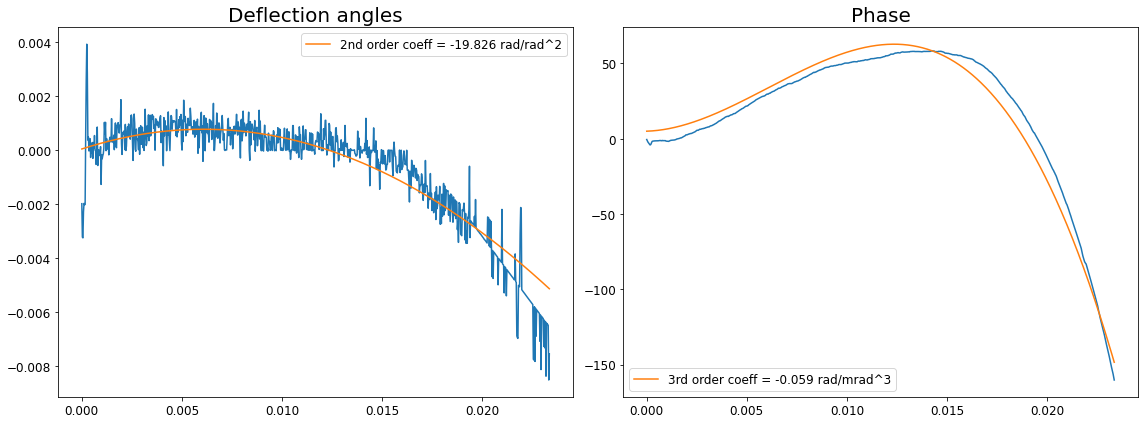

In [359]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_andrew_1727.pdf')

In [85]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=200, l_scale=7., n_iter=5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var)

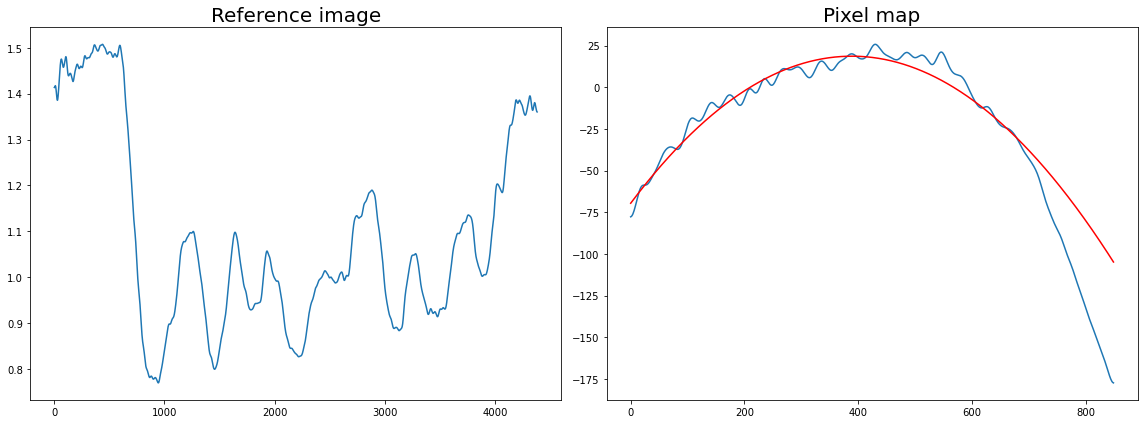

In [86]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_1896.pdf')

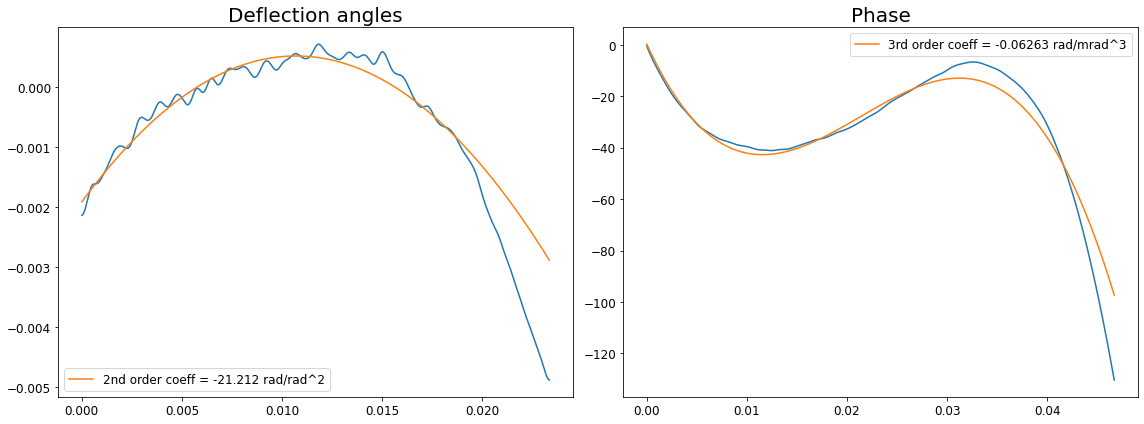

In [87]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(2 * phr_res['theta'], phr_res['phase'])
axes[1].plot(2 * phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_1896.pdf')